# Sequence Models & Attention Mechanism

## Basic Models

Start with basic models and move on.

Reference paper by Ilya Senpai: https://proceedings.neurips.cc/paper/2014/file/a14ac55a4f27472c5d894ec1c3c743d2-Paper.pdf 

Working example is French to English translation.

$x^{<i>}$ are input sequences and $y^{<j>}$ are output sequences.


Encoder network:

- First you have an encoder step.
- Input the french words one word at a time.
- After inputting all words, we get the last step output as the sentence representation.

Decoder network:

- Another RNN step to output the translated sequence one word at a time.
- Very remarkable that this approach works!!!


Similar encoder-decoder approach also works for image captioning:

- Use an encoder network to get a 4096-dim feature vector of input image
- Use an RNN decoder network to generate the caption!! 
- So simple and works


One important difference between the above model and sampling from a language model is that for the translation, we don't want random words being sampled. We want the most likely translation!! Thus motivating the beam search


## Picking the Most Likely Sentence

Machine translation builds a conditional language model.

Decoder looks identical to a language model sampling. Where the only difference is instead of starting with zero assumption, we condition the generation using the encoding that was the output of the encoder. 

So $a^{<0>}$ the dummy input of language model is replaced with french sentence encoding.


### Finding the most likely Translation

- If we sample randomly, we might generate words that are less likely or sample incorrect and deviate.

- We want to sample a sequence that maximizes the likelihood

- Most common approach is to use beam search

**Why not greedy??**

Well what if it starts very good and then subsequent words are actually not very likely. You want to entire sequence to be very likely.

We need approach that can be more long term and consider future things.

**Why not exhaustive search**? Well you would need exponentially large computation. For 10 word sequencee with 10k vocab. you would calculate 100k sequences.

## Beam Search

10k vocab

- Step 1, given the encoders output, calculate softmax for whole vocab.
- b=3, pick the top three most likely first words and add them to your beam.
- Step 2, for each of the three words, calculate the second words.
- Pick the most likely 3 two-word sequences out of all options (3x10k continuations). So we are down to b=3 at the end of step 2 as well.
- Notice that as we move in each time step, we multiply the probability of all words until that time step.
- Also notice that if some continuation was unlikely we might get all continuations from one single first word. This would ignore the other two word candidates for word 1. 


At one point some beam search will yield `<EOS>` and we would output that.

## Refinements to Beam Search

### Length Normalization

- Notice that the outputs might differ in length. 
- Since we multiply the probabilities, longer sequences will always have lower value!!
- First we take log so we get sum of logs. So more numerically stable.
- We should divide by length to account:

$$
\text{argmax} \dfrac{1}{T_y^{\alpha}}\sum_{t=1}^{T_y} log P(y^{<t>} | x,y^{<1>}, ... , y^{<t-1>})
$$

where $\alpha$ can be somewhere between 0 and 1 to decide the length tradeoff.


How you run beam search? 

Set $T_y= 1,2,3,4,....,30$ and run for all values. 

Store the best result from each length. Finally get the most likely sequence with length normalization applied.


### Beam width B?

- If B is very large: better results and slower (memory requirements high)
- B is small: worse results, faster

B is very domain and application dependent. Usually there is diminishing returns.

Of course Beam search is faster but is not guaranteed to find exact maximum for argmax!!

## Error Analysis on Beam Search

What if beam search makes a mistake? Lets see how we can conduct error analysis.


    French: Jane visite l'Afrique en septembre.
    Human: ($y^*$)Jane visits Africa in September.
    Algorithm: ($\hat{y}$)Jane visited Aftica last September (prediction not very good)
    

Two components in your system:
- RNN
- Beam Search

It would be great if we could attribute the mistake to either of these two components. So we know which one to focus on. It is always tempting to increase B but this might not fix the issue actually


Let's break the problem down.

- RNN computes $P(y|x)$
- Compute $P(y^*|x)$ and $P(\hat{y}|x)$ and see which of these have higher probability.
- If $y^*$ is higher than not really problem from RNN side!! We should increase beam in that case maybe?


#### Case 1. $P(y^*|x) > P(\hat{y}|x)$

Conclusion: Beam search is at fault.


#### Case 2. $P(y^*|x) \leq P(\hat{y}|x)$

Conclusion: RNN had bad prediction. 

Of course there are some subtleties about length normalization etc. we should incoroporate.


### Error analysis process.

- Go over all mistakes by your model.
- Repeat the above approach for all samples
- Count the number of cases where beam search and RNN are making mistake.

Maybe we find out that 80% of cases where RNN fault or other way.



## BLEU Score 

One of the challenges is how do we evaluate a machine translation where there could be multiple correct answers.

Lets remember how it works.


    French: Le chat est sur le tapis.
    Reference 1: The cat is on the mat.
    Reference 2: There is a cat on the mat.
    
BLEU attempts to quantify the goodness of a machine translation automatically. BLEU stands for bilingual evaluation understudy. Understudy means taking the role of more advanced actor, motivation: computer takes the role of human to evaluate the outputs.


Extreme example.

    MT output: the the the the the the the.


### Potential Solution.

Precision: Check how many times each word in the translation occur in one of the references. This would give perfect score to MT output: $7/7 = 1$

Modified Precision: Only count a word up to maximum times it appears in any of the references. So `the` can be counted at most twice (2 in ref1 and 1 in ref2). So we would get $2/7$ as the precision.


You don't want to look at words in isolation. So we can calculate BLEU score on bigrams instead.


    MT output: The cat the cat on the mat. 
    

bigrams:

- the cat: 2         
- cat the: 1
- cat on : 1
- on the : 1
- the mat: 1

Then count the times they (the bigrams) appear in the reference to count how much credit we can give to each.

Modified precision: $\dfrac{4}{6}$

Formalized formula:


$$
P_1 = \dfrac{\sum_{\text{unigrams}} \text{Count}_{clip}(unigram)}{\sum_{\text{unigrams}} \text{Count}(unigram)}\\
P_n = \dfrac{\sum_{\text{n-grams}} \text{Count}_{clip}(n-gram)}{\sum_{\text{n-grams}} \text{Count}(n-gram)}\\
$$

In the other extreme, if out MT output is identical we can get full score on both P1 and Pn.



**BLEU Details.**

\text{BLEU} = \text{BP} exp(\dfrac{1}{4} \sum_{n=1}^4 P_n)

$BP$ stands for `brewity penalty`. Penalizes very short outputs.

BP is defined as:

- 1 if MT output is longer than reference outputs
- $exp(1 - \text{reference_length} / \text{MT_length})$ otherwise


BLEU was revolutionary because it gave us a single evaluation metric (not perfect but still) to evaluate MT systems!! 

## Attention Model Intuition

We have been using encoder-decoder approach.

The problem of long sequences:

- We ask the encoder to be able to encode everything inside a very long sequence into a single representation and ask decoder to be able to utilize it to retain all the information. 


- However, what a human translator would do is that they would NOT read the long input sentence and then output the full translation. It is more of an iterative process: they read beginning take note and go back and forth several times instead of memorizing the input.

- Actually it is shown that BLEU score drops on long sentences for encoder-decoder RNN models.

- Attention models are shown that they can retain performance on long sequences!!


**Intuition**

Reference paper by Bahdanau: https://arxiv.org/pdf/1409.0473.pdf 

- In RNN decoder, for each step, we only used the previous generation and the context from previous step.

- In the Attention-based model, at each step we have an activation $\alpha^{<i,j>}$ that determines how much the output that we will generate at step $i$ should attent to context representation generated for input $j$.

- For all input steps, we calculated an activation $a^{<t>}$ as you see below.

- We use these values in combination with the $\alpha$ values to construct the context representation for the decoder at step $i$

- This way each output can focus attention to different parts of input as would a human translator do.

- We learn $\alpha$ using learnable parameters with gradient descent. 

- Note that at each step $\alpha^{<1,x>}$ and $\alpha^{<2,x>}$ will be different. Alpha is constructed using the input activations and the output of the decoder from the previous time step $y^{<t-1>}$



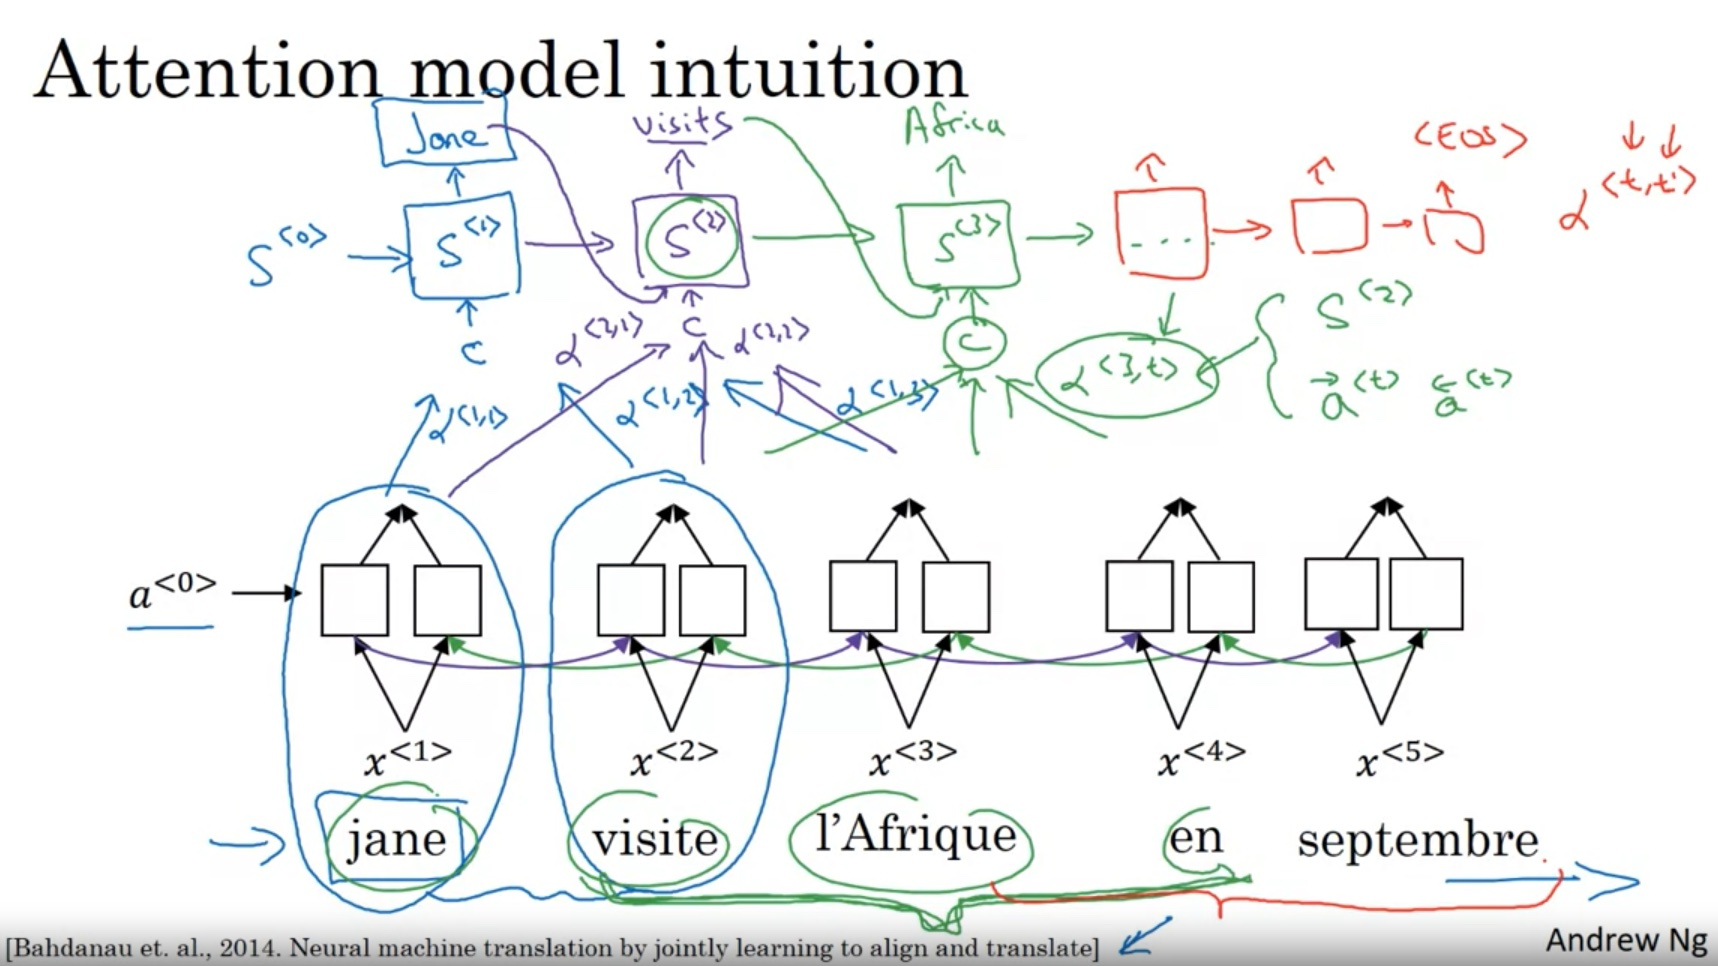

In [2]:
from IPython.display import Image
Image(filename='../../assets/attention_intuition.jpg')

## Attention Model

Let's layout the details of the attention model now in a more formal way.


- First we use some kind of BiRNN like BiLSTM to compute activations for each input step:

$$
a^{<t^{'}>} =[\overrightarrow{a}^{<t^{'}>}, \overleftarrow{a}^{<t^{'}>} ]
$$

$t^{'}$ denotes the input indices. to simplify notation let's just use $a^{<t^{'}>}$ for that concatenation.


Decoder:

- The decoder at each step will have an input: $c^{<1>}$ etc.
- c depends on some values $\alpha^{<1,1>},\alpha^{<1,2>},\alpha^{<1,t^{'}>}$ that determines how much we attend to each input.


$$
\sum_{t^{'}}  \alpha^{<t,t^{'}>} = 1 \\
c^{<t>} = \sum_{t^{'}} \alpha^{<t,t^{'}>} \cdot a^{<t^{'}>}
$$

So c is a weighted sum of input layer activations.


- $\alpha^{<t,t^{'}>}$ is the attention $y^{<t>}$ should pay attention to input word $t^{'}$.


- At all steps we input the generated $y^{<t-1>}$ from previous step.


#### How to calculate $\alpha$


We use softmax style to make sure the alphas add up to 1.

$$
\alpha^{<t,t^{'}>} = \dfrac{exp(e^{<t,t^{'}>})}{\sum_{t^{'}} exp(e^{<t,t^{'}>)}}
$$


**How do we calculate these e's ?** 

We have a small neural network that learns them (usually one layer hidden network).


Inputs:   
- $s^{<t-1>}$ (activation of the decoder from the previous time step)
- $a^{<t^{'}>}$ which is the activation from the input at step $t^{'}$
    
Output:
    - $e^{<t,t^{'}>}$
    
Intuition: In order to calculate how much attention we should pay, we can learn from the activation of the previous step and the word itself.


    
So we run the above network for all input steps $T_x$ to calculate all alpha values. 

Note that this makes this approach expensive since the computation is Quadratic (x times y). If we generate 10 words and our input is 100, we do 1000 computations.

Nice thing is that in Natural language the lengths are not millions etc. so quadratic is still tolerable.



**Final notes:** 

- Image captioning apparently can also benefit from similar approach.
    - Each output pays attention to certain part of the input.
- Visualization on attention weights as a confusion matrix is super interesting and confirm the words attent to correct input words during MT.

## Speech Recognition

Speech Recognition is one exciting application of sequence-to-sequence models.

Input is audio clip (which is essentially an air pressure measure across time)

- Common way to preprocess is to generate a spectogram
- Show strength of frequencies at each time step.


Output is the transcript


Historically we used phonemes which are units of sound represented as text was the way to go for speech recognition.

With Deep Learning, we can simply do end-to-end without using hand engineered representations such as phonemes.


### How do you build speech recognitio model??

Actually one common solution is simply use the attention model we described. Input is the spectogram value at each time step. Then use attention model with an RNN decoder to predict the correct transcript


#### CTC: Connectionist Temporal Classification

Example:
    The quick brown fox
    
- Imagine the input audio. It is continuous and sampled frequently maybe 200 data points per second.
- On the contrary the transcript is just 4 words with 19 characters
- CTC helps us generate one prediction for each input time step and collapse them.


Rules of CTC.

- Collapse repeated characters not separated by "blank" (_)
- Ignore all the blank characters

So model predicts something like:

    ttt_h_eee____<space>____qqqq______
    
This will be decoded as:

    the q
    

This proved to be a very good way of formulating the sequence to sequence problem.



## Trigger Word Detection

(Application that requires only small amount of data for training)

Trigger word:

- Apple: Hey Siri!
- Amazon Echo: Alexa



How to build model for trigger word detection?? 

- Well you get an input signal such as audio recording.

- Label everything that is before the trigger word as 0

- Label the couple milliseconds around when we hear the trigger word as 1.

- If we only label the exact moment when we hear the trigger word, we might suffer from big imbalanced data.